**Απόστολος Μουστάκης**

**AM: 03400182**

<font color='darkred'>Οι απαντήσεις σε όλα τα ερωτήματα γράφονται με αυτό το χρώμα ώστε να ξεχωρίζουν από τις εκφωνήσεις </font>

# **Άσκηση στους Autoencoders**

Στα πλαίσια της άσκησης θα εξετάσετε πως δουλεύει ένας αυτόματος κωδικοποιητής (autoencoder) για την ταξινόμηση ενός συνόλου δεδομένων.



In [ ]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot

Θα χρησιμοποιήσουμε τη συνάρτηση make_classification() scikit-learn για να ορίσουμε ένα συνθετικό σύνολο δεδομένων ταξινόμησης (2 κλάσεων) με 100 χαρακτηριστικά εισόδου (στήλες) και 1.000 παραδείγματα (γραμμές). 

**Προσοχή**: *Στο δοθέν πρόβλημα τα περισσότερα από τα χαρακτηριστικά είναι περιττά κατά 90%, επιτρέποντας στον autoencoder αργότερα να μάθει μια πραγματικά χρήσιμη συμπιεσμένη αναπαράσταση.*


In [ ]:
# synthetic classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# number of input columns
n_inputs = X.shape[1]
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


Στη συνέχεια, θα αναπτύξουμε ένα μοντέλο αυτόματου κωδικοποιητή [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

Το μοντέλο θα λάβει όλες τα παραδείγματα στην είσοδο και μετά θα εξάγει τις ίδιες τιμές.Συνεπώς θα μάθει να αναδημιουργεί το ίδιο μοτίβο

Ο αυτόματος κωδικοποιητής αποτελείται από δύο μέρη τον κωδικοποιητή και τον αποκωδικοποιητή.

Μόλις εκπαιδευτεί ο autoencoder, ο αποκωδικοποιητής δεν θα χρησιμοποιηθεί ξανά και κρατάμε μόνο τον κωδικοποιητή για να συμπιέσουμε παραδείγματα εισόδου στα διανύσματα που εξάγονται από το bottleneck.

Σε αυτόν τον πρώτο αυτόματο κωδικοποιητή, δεν θα συμπιέσουμε καθόλου την είσοδο και θα χρησιμοποιήσουμε ενδιάμεσες συνάψεις ίδιου αριθμού με τον αριθμό των κόμβων εισόδου (άρα ίσο με τον αριθμό των διαστάσεων του δείγματος). Αυτό θα εφαρμοστεί ώστε το μοντέλο να μάθει σχεδόν τέλεια και να επιβεβαιώσουμε ότι το μοντέλο έχει εφαρμοστεί σωστά.

Πριν ορίσουμε και προσαρμόσουμε το μοντέλο, θα χωρίσουμε τα δεδομένα σε σύνολα εκπαίδευσης και δοκιμής και θα κλιμακώσουμε τα δεδομένα εισόδου κανονικοποιώντας τις τιμές στο εύρος 0-1.

In [ ]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

Θα ορίσουμε ότι ο κωδικοποιητής θα έχει δύο κρυφά επίπεδα, το πρώτο με διπλάσιο αριθμό διαστάσεων εισόδου (π.χ. 200) και το δεύτερο με τον αρχικό αριθμό διαστάσεων (100).


In [ ]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

Στη συνέχεια ορίζουμε τον αποκωδικοποιητή. Ο αποκωδικοποιητής θα έχει την αντίστροφη δομή από τον κωδικοποιητή.

In [ ]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

Στη συνέχεια κάνουμε compile το μοντέλο μας.

In [ ]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

Στη συνέχεια, μπορούμε να εκπαιδεύσουμε το μοντέλο να αναπαράγει τα δεδομένα εισόδου και να παρακολουθεί την απόδοση του μοντέλου σε σύγκριση με το test set.

**Ερώτηση 1**: Ποια είναι η διαφορά μεταξύ mini-batch και epochs


<font color='darkred'>Ο αριθμός των εποχών (epochs) είναι μια υπερπαράμετρος που καθορίζει το πόσες φορές ο αλγόριθμος εκμάθησης θα επεξεργαστεί το σύνολο των δεδομένων εκπαίδευσης.

<font color='darkred'>Ο αριθμός των batches/mini-batches είναι μία υπερπαράμετρος που καθορίζει τον αριθμό των δειγμάτων προς επεξεργασία πριν από την ενημέρωση των εσωτερικών παραμέτρων του μοντέλου ανά εποχή.

<font color='darkred'>Μπορούμε να σκεφτούμε την όλη διαδικασία ως εξής:
*   Έχουμε ένα for loop για τον αριθμό των εποχών όπου κάθε φορά επεξεργάζεται το σύνολο των δεδομένων εκπαίδευσης
*   Μέσα σε αυτό το for loop έχουμε ένα ακόμη for loop για τον αριθμό των batches, το οποίο επαναλαμβάνεται ανάλογα το μέγεθος του batch.</font>

<font color='darkred'>Έστω οτι έχουμε $N$ δείγματα. Στο batch training ισχύει batch size $= N$ και συνεπώς ανά εποχή το μοντέλο επεξεργάζεται το σύνολο των δεδομένων και ύστερα ανανεώνει τις παραμέτρους. Στο mini-batch training ισχύει batch size $= α$, όπου $a <= N$ και συνεπώς οι παράμετροι του μοντέλου ανανεώνονται κάθε $a$ δείγματα. Ανά εποχή λοιπόν θα έχουμε $N/a$ ανανεώσεις των παραμέτρων. Mία ακράα περίπτωση mini-batch training αποτελεί ο αλγόριθμος Stochastic Gradient Descent όπου batch size $= 1$ (οι παράμετροι ανανεώονται κάθε ένα δείγμα). 






In [ ]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

Παρακάτω παρατείθενται οι καμπύλες μάθησης για το train και το test dataset.

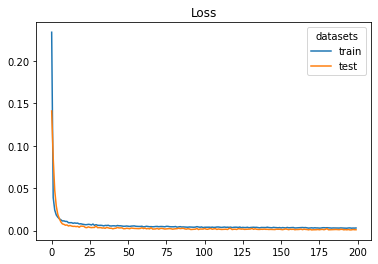

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

<font color='darkred'>Παρακάτω παραθέτω το ίδιο διάγραμμα με προηγουμένως με αλλαγή στην κλίμακα y για καλύτερη ευκρίνεια. 

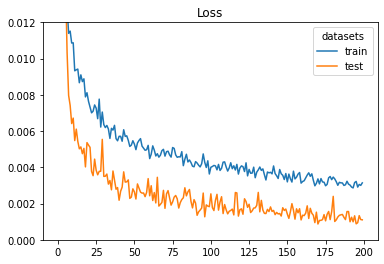

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.ylim([0,0.012]) #ύστερα από δοκιμές
pyplot.show()

**Ερώτηση 2**: Δοκιμάστε να τρέξετε το μοντέλο με Bottleneck: α) 50 και β) 25. Τι παρατηρείτε ως προς τα αποτελέσματα του μοντέλου;

<font color='darkred'>Παρακάτω τρέχουμε το μοντέλο με Bottleneck = 50 και τυπώνουμε τις καμπύλες μάθησης για το train και το test dataset όπως προηγουμένως

In [ ]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 50  # Bottleneck = 50
bottleneck = Dense(n_bottleneck)(e)

In [ ]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [ ]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

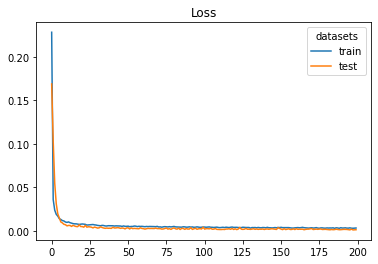

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

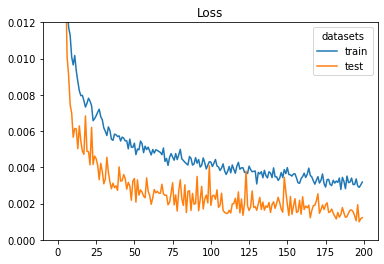

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.ylim([0,0.012]) #ύστερα από δοκιμές
pyplot.show()

<font color='darkred'>Παρακάτω τρέχουμε το μοντέλο με Bottleneck = 25 και τυπώνουμε τις καμπύλες μάθησης για το train και το test dataset όπως προηγουμένως

In [ ]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 25  # Bottleneck = 25
bottleneck = Dense(n_bottleneck)(e)

In [ ]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [ ]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

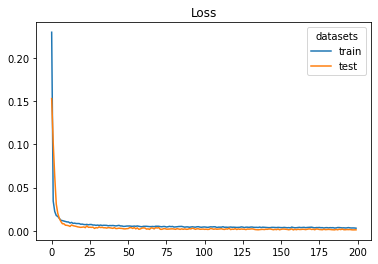

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

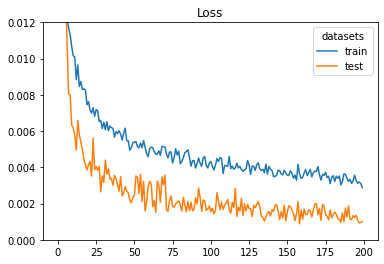

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.ylim([0,0.012]) #ύστερα από δοκιμές
pyplot.show()

<font color='darkred'>Τα αποτελέσματα του μοντέλου δεν φαίνονται τόσο καλά στο πρώτο διάγραμμα και για αυτό κάθε φορά επέλεξα να εστιάζω στο διάστημα [0,0.012] όσον αφορά την y κλίμακα. Στόχος είναι να έχουμε μικρή απώλεια στο test set ώστε ο αυτόματος κωδικοποιητής να γενικεύει καλά σε νέα δεδομένα. Αυτό που αξίζει να παρατηρήσουμε είναι πως σε όλες τις περιπτώσεις το μέγεθος του Bottleneck (100, 50 και 25 αντίστοιχα) δεν επηρεάζει αισθητά την εκπαίδευση του αυτόματου κωδικοποιητή, δεδομένων των παραμέτρων του μοντέλου όπως ο αριθμός των εποχών και το batch size. 

<font color='darkred'>Αν το μέγεθος του Bottleneck είναι πολύ μικρό τότε ενδέχεται ο αυτόματος κωδικοποιητής να μην μπορεί να καταγράψει με μεγάλη αποτελεσματικότητα τα χαρακτηριστικά των δεδομένων, το οποίο οδηγεί σε κακή ποιότητα ανακατασκευής. Στην συγκεκριμένη άσκηση φαίνεται πως και το μικρότερο μέγεθος Bottleneck που χρησιμοποιείται (25) είναι αρκετό για να αποκωδικοποιηθεί η πληροφορία. Με μικρότερα μεγέθη Bottleneck μπορεί να υπάρξει πρόβλημα. 


**Ερώτηση 3**: δοκιμάστε να βάλετε τρία επίπεδα (τα δύο υφιστάμενα και ένα ακόμα με bottleneck 50). Τι διαφορές παρατηρείτε;

<font color='darkred'>Αποφασίζουμε να προσθέσουμε ένα επιπλέον κρυφό επίπεδο στον κωδικοποιητή, με το μισό αριθμό διαστάσεων εισόδου (50). Ο αποκωδικοποιητής έχει την αντίστροφη δομή από τον κωδικοποιητή οπότε αλλάζουμε και αυτό το μέρος του κώδικα. Τρέχουμε το μοντέλο με Bottleneck = 50. 

In [ ]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 3  #the extra level
e = Dense(n_inputs/2)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 50  # Bottleneck = 50
bottleneck = Dense(n_bottleneck)(e)

In [ ]:
# define decoder, level 1
d = Dense(n_inputs/2)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 3
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [ ]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

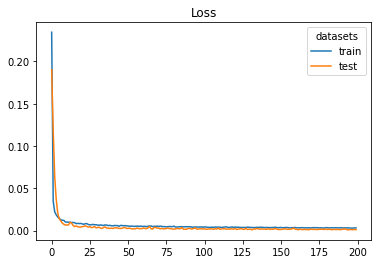

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

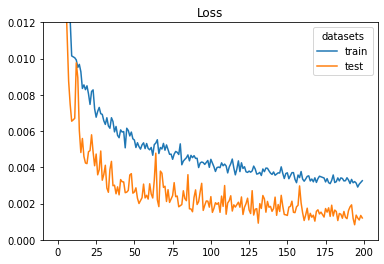

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.ylim([0,0.012]) #ύστερα από δοκιμές
pyplot.show()

<font color='darkred'>Η προσθήκη ενός έξτρα επιπέδου μπορεί να οδηγήσει μεταξύ άλλων σε αύξηση του χρόνου εκπαίδευσης και σε μείωση του σφάλματος ανακατασκευής, καθώς το επιπλέον επίπεδο μπορεί να μάθει πιο ουσιαστικές και περίπλοκες αναπαραστάσεις των δεδομένων εισόδου. Ωστόσο, στο συγκεκριμένο παράδειγμα δεν αυξάνεται ο χρόνος εκπαίδευσης (απλό παράδειγμα), ενώ τα αποτελέσματα του διαγράμματος που αφορούν τις καμπύλες μάθησης για το train και το test dataset παραμένουν σχεδόν ίδια με προηγουμένως. Αυτό μπορεί να συμβεί καθώς ο προηγούμενος αυτόματος κωδικοποιητής με τα δύο στρώματα ήταν επαρκής για την αναπαράσταση των δεδομένων και συνεπώς το επιπλέον επίπεδο δεν έχει κάποια ουσιαστική χρησιμότητα. 